[KMeans] Best-matched accuracy (post-hoc label mapping): 0.5417


ValueError: operands could not be broadcast together with shapes (1000,) (10715,) 

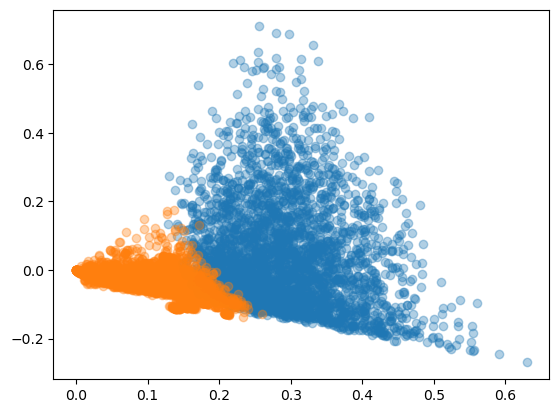

In [1]:
# save as: /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/data_processing/visualize_models.py
# Generates performance visualizations for Naive Bayes (classification) and K-Means (clustering).
# Outputs saved under: Assignment_2/outputs/analyze_models/

from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib
# Use non-interactive backend if running as a script
if not any(k.startswith("JPY_PARENT_PID") for k in os.environ):
    matplotlib.use("Agg")
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from scipy.optimize import linear_sum_assignment

# ---------------- Paths ----------------
try:
    THIS_DIR = Path(__file__).parent
except NameError:
    THIS_DIR = Path.cwd()

# Move up to the project root (cos30049_spam_detection) and include Assignment_2
ROOT = THIS_DIR.parent / "Assignment_2"

PROCESSED = ROOT / "outputs" / "processed"
TRAIN = PROCESSED / "emails_merged.train.csv"
TEST  = PROCESSED / "emails_merged.test.csv"
MERGED = PROCESSED / "emails_merged.processed.csv"

OUTDIR = ROOT / "outputs" / "analyze_models"
OUTDIR.mkdir(parents=True, exist_ok=True)



# ---------------- Helpers -------------
def load_xy(path: Path):
    df = pd.read_csv(path)
    return df["text"].astype(str).tolist(), df["label"].astype(int).values

def save_fig(fig, path: Path):
    fig.tight_layout()
    fig.savefig(path, dpi=140)
    plt.close(fig)

# ============== A) Naive Bayes (classification) ==============

# 1) Train on TF-IDF (same choices used earlier)
X_train, y_train = load_xy(TRAIN)
X_test,  y_test  = load_xy(TEST)

nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(min_df=5, ngram_range=(1,2))),
    ("nb", MultinomialNB(alpha=0.5))
])
nb_pipe.fit(X_train, y_train)

y_pred = nb_pipe.predict(X_test)
y_proba = nb_pipe.predict_proba(X_test)[:, 1]

# --- Plot 1: Confusion Matrix (NB) ---
cm = confusion_matrix(y_test, y_pred)  # [[TN, FP], [FN, TP]]
fig1 = plt.figure()
ax = fig1.gca()
im = ax.imshow(cm, cmap="Blues")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["True 0","True 1"])
ax.set_title("Naive Bayes — Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
fig1_path = OUTDIR / "nb_confusion_matrix.png"
save_fig(fig1, fig1_path)

# --- Plot 2: ROC Curve (NB) ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
fig2 = plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes — ROC Curve")
plt.legend()
fig2_path = OUTDIR / "nb_roc_curve.png"
save_fig(fig2, fig2_path)

# --- Plot 3: Precision–Recall Curve (NB) ---
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
fig3 = plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Naive Bayes — Precision–Recall Curve")
plt.legend()
fig3_path = OUTDIR / "nb_precision_recall_curve.png"
save_fig(fig3, fig3_path)

# ============== B) K-Means (clustering) ==============

# Use the full merged set for clustering (unsupervised fit)
df_all = pd.read_csv(MERGED)
texts = df_all["text"].astype(str).tolist()
y_true = df_all["label"].astype(int).values  # used only for evaluation/plot coloring

tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,2))
X = tfidf.fit_transform(texts)

# Dimensionality reduction for clustering + visualization
svd = TruncatedSVD(n_components=100, random_state=42)
X_red = svd.fit_transform(X)

km = KMeans(n_clusters=2, n_init=20, random_state=42)
clusters = km.fit_predict(X_red)

# --- Plot 4: Silhouette Distribution (KMeans) ---
sil_vals = silhouette_samples(X_red, clusters)
fig4 = plt.figure()
plt.hist(sil_vals, bins=30)
plt.xlabel("Silhouette score")
plt.ylabel("Count")
plt.title("K-Means — Silhouette Score Distribution")
fig4_path = OUTDIR / "kmeans_silhouette_hist.png"
save_fig(fig4, fig4_path)

# --- Plot 5: Contingency Heatmap (true label vs cluster) ---
cont = pd.crosstab(y_true, clusters).values  # rows=true(0/1), cols=cluster(0/1)
fig5 = plt.figure()
ax5 = fig5.gca()
im5 = ax5.imshow(cont, cmap="Greens")
for (i, j), v in np.ndenumerate(cont):
    ax5.text(j, i, str(v), ha="center", va="center")
ax5.set_xticks([0,1]); ax5.set_yticks([0,1])
ax5.set_xticklabels(["Cluster 0","Cluster 1"]); ax5.set_yticklabels(["True 0","True 1"])
ax5.set_xlabel("Cluster"); ax5.set_ylabel("True Label")
ax5.set_title("K-Means — Contingency Table Heatmap")
fig5_path = OUTDIR / "kmeans_contingency_heatmap.png"
save_fig(fig5, fig5_path)

# Compute best-matched accuracy for reference (not a plot, but useful)
row_ind, col_ind = linear_sum_assignment(cont.max() - cont)
matched_acc = cont[row_ind, col_ind].sum() / cont.sum()
print(f"[KMeans] Best-matched accuracy (post-hoc label mapping): {matched_acc:.4f}")

# --- Plot 6: 2D SVD Scatter (KMeans), colored by cluster; overlay true labels as markers
# Further reduce to 2D for visualization only
svd2 = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd2.fit_transform(X)

fig6 = plt.figure()
# color by cluster; marker shape by true label (o for 0, x for 1)
mask0 = y_true == 0
mask1 = y_true == 1
plt.scatter(X_2d[clusters==0, 0], X_2d[clusters==0, 1], alpha=0.35, label="Cluster 0")
plt.scatter(X_2d[clusters==1, 0], X_2d[clusters==1, 1], alpha=0.35, label="Cluster 1")
# overlay a small subset of true labels as markers to avoid clutter
idx = np.linspace(0, len(X_2d)-1, num=min(1000, len(X_2d))).astype(int)
plt.scatter(X_2d[idx & mask0, 0], X_2d[idx & mask0, 1], marker="o", s=10, alpha=0.8, label="True 0 (subset)")
plt.scatter(X_2d[idx & mask1, 0], X_2d[idx & mask1, 1], marker="x", s=10, alpha=0.8, label="True 1 (subset)")
plt.title("K-Means — 2D SVD Scatter (clusters + true-label overlay)")
plt.xlabel("SVD-1")
plt.ylabel("SVD-2")
plt.legend(loc="best")
fig6_path = OUTDIR / "kmeans_svd2_scatter.png"
save_fig(fig6, fig6_path)

# ---------------- README listing ----------------
with open(OUTDIR / "README.txt", "w", encoding="utf-8") as f:
    f.write(
        "Model Performance Figures\n"
        f"- {fig1_path.name}: Naive Bayes Confusion Matrix\n"
        f"- {fig2_path.name}: Naive Bayes ROC Curve\n"
        f"- {fig3_path.name}: Naive Bayes Precision–Recall Curve\n"
        f"- {fig4_path.name}: K-Means Silhouette Score Distribution\n"
        f"- {fig5_path.name}: K-Means Contingency Table Heatmap\n"
        f"- {fig6_path.name}: K-Means 2D SVD Scatter (clusters + true-label overlay)\n"
        f"\nExtra: printed best-matched accuracy (Hungarian mapping) for K-Means.\n"
    )

print(f"Saved figures to: {OUTDIR}")
